## Imports

In [40]:
import pandas as pd
import numpy as np
import re

from textblob import TextBlob, Word

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import scipy
from datetime import datetime

In [41]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.feature_extraction.text import CountVectorizer

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, ElasticNetCV
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, plot_roc_curve, f1_score, plot_precision_recall_curve

### Last clean before model

In [13]:
df = pd.read_csv('df_final_no_numbers.csv')
df.subtitle = df.subtitle.apply(lambda x: 0 if x == '-' else 1)
df.subtitle = df.subtitle.apply(str)
df.day_of_the_week = df.day_of_the_week.apply(str)
df = df[(df['publication'] != 'personal-growth')
        & (df['publication'] != 'uxplanet')]
df.reset_index(drop=True, inplace=True)

In [14]:
df.head()

,date,title,subtitle,claps,responses,author_handle,story_url,reading_time,text,author_followers,publication,number_of_words,number_of_characters,day_of_the_week,month,polarity,subjectivity,claps_per_quartile,claps_binary
0,01/01/2020,making python program blazingly fast,1,3400.0,3,@martin.heinz,https://towardsdatascience.com/making-python-p...,5,making python program blazingly fast let look ...,3800.0,towardsdatascience,1056,6175,2,1,0.049713,0.407731,3,1
1,01/01/2020,implementing fully convolutional network fcn t...,1,543.0,4,@himanshurawlani,https://towardsdatascience.com/implementing-a-...,11,understanding implementing fully convolutional...,331.0,towardsdatascience,2527,15729,2,1,0.110434,0.398271,3,1
2,01/01/2020,new feature python python newbie,1,1800.0,4,@edenau,https://towardsdatascience.com/6-new-features-...,4,python beginner new feature python python newb...,1700.0,towardsdatascience,712,4174,2,1,0.081111,0.470741,3,1
3,01/01/2020,fancy python,1,1700.0,12,@dipam44,https://towardsdatascience.com/how-to-be-fancy...,5,fancy python python cool really cool however l...,625.0,towardsdatascience,607,3328,2,1,0.209636,0.480786,3,1
4,01/01/2020,scratch search playing data elasticsearch inge...,1,239.0,1,@stanislavprihoda,https://towardsdatascience.com/from-scratch-to...,9,scratch search playing data elasticsearch inge...,88.0,towardsdatascience,2158,14087,2,1,0.090842,0.435970,3,1


------

## Simple look at data

In [15]:
df.publication.value_counts()

towardsdatascience    27195
datadriveninvestor    14261
swlh                   9986
uxdesign               6553
writingcooperative     4448
better-marketing       4418
better-humans          1506
the-mission             472
startup-grind           296
Name: publication, dtype: int64

In [16]:
df.describe()

,claps,responses,reading_time,author_followers,number_of_words,number_of_characters,month,polarity,subjectivity,claps_per_quartile,claps_binary
count,69135.000000,69135.000000,69135.000000,69135.000000,69135.000000,69135.000000,69135.000000,69135.000000,69135.000000,69135.000000,69135.000000
mean,257.153569,1.912938,6.491690,3780.866233,1314.883633,7971.710103,6.095711,0.117113,0.461171,1.504578,0.501309
std,806.714441,6.620316,3.584353,17869.251507,826.495984,5113.054354,3.486655,0.067479,0.064929,1.115267,0.500002
min,0.000000,0.000000,1.000000,1.000000,201.000000,1044.000000,1.000000,-0.373631,0.117686,0.000000,0.000000
25%,40.000000,0.000000,4.000000,57.000000,798.000000,4785.000000,3.000000,0.074728,0.421012,1.000000,0.000000
50%,95.000000,0.000000,6.000000,241.000000,1130.000000,6801.000000,6.000000,0.115497,0.463336,2.000000,1.000000
75%,222.000000,2.000000,8.000000,1300.000000,1607.000000,9754.000000,9.000000,0.158415,0.503280,3.000000,1.000000
max,70000.000000,433.000000,292.000000,268000.000000,17364.000000,100000.000000,12.000000,0.636302,0.782483,3.000000,1.000000


------

## Data Pre Processing

### Selecting X and y for models

In [17]:
df.publication.unique()


array(['towardsdatascience', 'swlh', 'writingcooperative',
       'datadriveninvestor', 'uxdesign', 'the-mission', 'startup-grind',
       'better-humans', 'better-marketing'], dtype=object)

In [18]:
y = df.claps_binary


In [19]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69135 entries, 0 to 69134
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   date                  69135 non-null  object 
 1   title                 69135 non-null  object 
 2   subtitle              69135 non-null  object 
 3   claps                 69135 non-null  float64
 4   responses             69135 non-null  int64  
 5   author_handle         69135 non-null  object 
 6   story_url             69135 non-null  object 
 7   reading_time          69135 non-null  int64  
 8   text                  69135 non-null  object 
 9   author_followers      69135 non-null  float64
 10  publication           69135 non-null  object 
 11  number_of_words       69135 non-null  int64  
 12  number_of_characters  69135 non-null  int64  
 13  day_of_the_week       69135 non-null  object 
 14  month                 69135 non-null  int64  
 15  polarity           

In [20]:
X_ = df[['title', 'text','subtitle', 'author_followers', 'publication', 'number_of_words', 'day_of_the_week', 'polarity', 'subjectivity']]
X_ = pd.get_dummies(X_, columns=['publication', 'day_of_the_week', 'subtitle'], drop_first=True)

X_.head()

,title,text,author_followers,number_of_words,polarity,subjectivity,publication_better-marketing,publication_datadriveninvestor,publication_startup-grind,publication_swlh,...,publication_towardsdatascience,publication_uxdesign,publication_writingcooperative,day_of_the_week_1,day_of_the_week_2,day_of_the_week_3,day_of_the_week_4,day_of_the_week_5,day_of_the_week_6,subtitle_1
0,making python program blazingly fast,making python program blazingly fast let look ...,3800.0,1056,0.049713,0.407731,0,0,0,0,...,1,0,0,0,1,0,0,0,0,1
1,implementing fully convolutional network fcn t...,understanding implementing fully convolutional...,331.0,2527,0.110434,0.398271,0,0,0,0,...,1,0,0,0,1,0,0,0,0,1
2,new feature python python newbie,python beginner new feature python python newb...,1700.0,712,0.081111,0.470741,0,0,0,0,...,1,0,0,0,1,0,0,0,0,1
3,fancy python,fancy python python cool really cool however l...,625.0,607,0.209636,0.480786,0,0,0,0,...,1,0,0,0,1,0,0,0,0,1
4,scratch search playing data elasticsearch inge...,scratch search playing data elasticsearch inge...,88.0,2158,0.090842,0.435970,0,0,0,0,...,1,0,0,0,1,0,0,0,0,1


------

### Train test split

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X_, y, test_size=0.33, random_state=42, stratify=y)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)


(46320, 21)
(22815, 21)
(46320,)
(22815,)


### Work on training set

#### Cvec text of training set

In [22]:
cvec = CountVectorizer(ngram_range=(1,2), max_features=1000000)

X_train_text = cvec.fit_transform(X_train.text)
X_train_text.shape


(46320, 1000000)

#### Cvec title of training set

In [23]:
cvec_2 = CountVectorizer(ngram_range=(1,2))

X_train_title = cvec_2.fit_transform(X_train.title)
X_train_title.shape


(46320, 154499)

#### Turn remaining columns into sparse matrix form

In [24]:
train_to_sparse = X_train.drop(['title', 'text'], axis=1)
sparse_df_train = scipy.sparse.csr_matrix(train_to_sparse.values)


#### Merge three train columns together

In [25]:
X_train = scipy.sparse.hstack((X_train_text, X_train_title, sparse_df_train))
X_train.shape

(46320, 1154518)

-------

### Work on test set

#### Cvec text of test set

In [26]:
X_test_text = cvec.transform(X_test.text)
X_test_text.shape


(22815, 1000000)

#### Cvec title of test set

In [27]:
X_test_title = cvec_2.transform(X_test.title)
X_test_title.shape


(22815, 154499)

#### Turn remaining columns into sparse matrix form

In [28]:
test_to_sparse = X_test.drop(['title', 'text'], axis=1)
sparse_df_test = scipy.sparse.csr_matrix(test_to_sparse.values)


#### Merge three train columns together

In [29]:
X_test = scipy.sparse.hstack((X_test_text, X_test_title, sparse_df_test))
X_test.shape


(22815, 1154518)

In [30]:
scaler=StandardScaler(with_mean=False)

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [31]:
print(X_train.shape)
print(X_test.shape)

(46320, 1154518)
(22815, 1154518)


Adding the string title to each of the token feature names of the title column so that they can be distinguished from the text tokens when interpreting coefficients and feature importance

In [32]:
title_feature_names = [token + ' (Title)' for token in cvec_2.get_feature_names()]
title_feature_names[:10]


['aaa (Title)',
 'aaa dilemma (Title)',
 'aaa game (Title)',
 'aaa testing (Title)',
 'aadhaar (Title)',
 'aadhaar website (Title)',
 'aamas (Title)',
 'aamas free (Title)',
 'aapl (Title)',
 'aapl record (Title)']

In [33]:
feature_names = cvec.get_feature_names() + title_feature_names + list(train_to_sparse.columns)

## Modelling

### Logistic Regression

In [345]:
log_model = LogisticRegression(n_jobs=7, max_iter=5000)
log_model.fit(X_train, y_train)

cv = cross_val_score(log_model, X_train, y_train, cv=5)

print('Training Score:', log_model.score(X_train, y_train))
print('Test Score:', log_model.score(X_test, y_test))
print('Cross Validation Score:', cv)
print('Mean cross Validation Score:', cv.mean())
print('Standard Deviation of Cross Validation Score:', cv.std())

Training Score: 1.0
Test Score: 0.6567609029147491
Cross Validation Score: [0.66126943 0.65695164 0.66126943 0.66429188 0.65500864]
Mean cross Validation Score: 0.6597582037996546
Standard Deviation of Cross Validation Score: 0.0033333780769635056


In [346]:
y_pred = log_model.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.64      0.70      0.67     11378
           1       0.67      0.61      0.64     11437

    accuracy                           0.66     22815
   macro avg       0.66      0.66      0.66     22815
weighted avg       0.66      0.66      0.66     22815



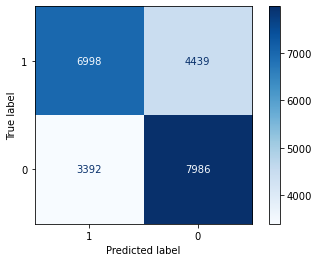

In [347]:
plot_confusion_matrix(log_model, X_test, y_test, cmap='Blues', labels=[1, 0], values_format='.0f')
plt.show()

#### Model Coefficients

Extracting the absolute value of all the coefficients so we know how much of an influence they have on the target, whether positive or negative.

In [ ]:
log_coef = log_model.coef_[0]
absolute_values = np.absolute(log_coef)

In [380]:
def calc_effect(coefs): 
    effect = []
    for item in coefs:
        if item > 0:
            effect.append('Positive')
        elif item < 0:
            effect.append('Negative')
        else:
            effect.append('No Effect')
    
    return effect

In [349]:
dict_features = {'feature_names': feature_names,
                 'absolute_coefs': absolute_values, 'effect': effect}
log_coefs_absolute = pd.DataFrame(dict_features).sort_values(
    'absolute_coefs', ascending=False).head(30)
log_coefs_absolute

,feature_names,absolute_coefs,effect
1154503,publication_better-marketing,0.079156,Positive
1154504,publication_datadriveninvestor,0.075855,Negative
1154517,subtitle_1,0.064069,Positive
1154499,author_followers,0.046744,Positive
1154509,publication_uxdesign,0.032421,Positive
1154510,publication_writingcooperative,0.031329,Positive
1145710,ux week (Title),0.031199,Positive
1049433,feeling fomo (Title),0.030186,Negative
1111933,regret life (Title),0.022819,Negative
1081213,manage chronic (Title),0.022033,Positive


------

The presence of a these features will result in an increase or decrease of logit(p) of the value of the coefficients. Where logit(p) is log(p/1-p). and p is the probability of Y being class 1. 

Y can take two values, either 0 or 1. P{Y=1} is called the probability of success. Hence logit(p) = log(P{Y=1}/P{Y=0}). This is called the log-odds ratio.

Hence a 1 unit increase in X₁ (or in this case, the presence of the feature) will result in b increase in the log-odds ratio of success : failure.

The log-odds ratio is simply the logarithm of the odds ratio. The reason logarithm is introduced is simply because the logarithmic function will yield a lovely normal distribution while shrinking extremely large values of P{Y=1}/P{Y=0}. Also, the logarithmic function is monotonically increasing, so it won’t ruin the order of the original sequence of numbers.

Lets take the case of having python in the title: It will result in a 1.036517 increase in logit(p) or log(p/1-p). Now, if log(p/1–p) increases by 1.036517, that means that p/(1 — p) will increase by exp(1.036517) = 2.81.

This is a 181% increase in the odds of belonging to class 1, i.e having an amount of claps higher than 95 (assuming that the variable female remains fixed).


In [350]:
fig = px.bar(log_coefs_absolute, x='absolute_coefs',
             y='feature_names', color='effect', title='Absolute coefficients', width=700, height=800)

fig.show()

-----

#### Coefficients for each category i.e Text, Title and other features

In [370]:
print(len(cvec.get_feature_names()))
print(len(title_feature_names))
print(len(train_to_sparse.columns))
print(len(feature_names))

1000000
154499
19
1154518


In [386]:
n_effect = calc_effect(log_coef[-19:])

In [388]:
n_features_dict = {'Feature names': train_to_sparse.columns,
                   'Absolute coefficients': np.absolute(log_coef[-19:]), 'Effect': n_effect}
feautres_coef_df = pd.DataFrame(n_features_dict).sort_values(
    by='Absolute coefficients', ascending=False)

In [394]:
fig = px.bar(feautres_coef_df, y='Absolute coefficients',
             x='Feature names', color='Effect', title='Absolute coefficients', width=900, height=600)

fig.show()

------

Title

In [401]:
n_effect = calc_effect(log_coef[1000000:1154499])

In [406]:
n_features_dict = {'Feature names': title_feature_names,
                   'Absolute coefficients': np.absolute(log_coef[1000000:1154499]), 'Effect': n_effect}
feautres_coef_df = pd.DataFrame(n_features_dict).sort_values(
    by='Absolute coefficients', ascending=False).iloc[:15,:]
feautres_coef_df

,Feature names,Absolute coefficients,Effect
145710,ux week (Title),0.031199,Positive
49433,feeling fomo (Title),0.030186,Negative
111933,regret life (Title),0.022819,Negative
96869,pain diet (Title),0.022033,Positive
81213,manage chronic (Title),0.022033,Positive
128075,step help (Title),0.021529,Negative
152714,writing (Title),0.019775,Positive
79551,love data (Title),0.018979,Positive
35459,design (Title),0.018864,Positive
14232,bitcoinblockchain journey (Title),0.018762,Positive


In [407]:
fig = px.bar(feautres_coef_df, y='Absolute coefficients',
             x='Feature names', color='Effect', title='Absolute coefficients', width=900, height=600)

fig.show()

Text

In [408]:
n_effect = calc_effect(log_coef[:1000000])

In [410]:
n_features_dict = {'Feature names': cvec.get_feature_names(),
                   'Absolute coefficients': np.absolute(log_coef[:1000000]), 'Effect': n_effect}
feautres_coef_df = pd.DataFrame(n_features_dict).sort_values(
    by='Absolute coefficients', ascending=False).iloc[:15,:]
feautres_coef_df

,Feature names,Absolute coefficients,Effect
988608,writer,0.019512,Positive
987508,write,0.018401,Positive
989561,writing,0.018394,Positive
390519,here,0.017303,Positive
576360,next commerce,0.016353,Negative
98923,brought salesforce,0.015460,Negative
754862,salesforcecomcommerce,0.015452,Negative
469528,learn salesforcecomcommerce,0.015452,Negative
150602,commerce brought,0.015452,Negative
78169,beginning june,0.015304,Negative


In [411]:
fig = px.bar(feautres_coef_df, y='Absolute coefficients',
             x='Feature names', color='Effect', title='Absolute coefficients', width=900, height=600)

fig.show()

--------

### Logistic Regression - Grid Search

'saga' solver works faster for large datasets and also can be used in conjunction with l1 and l2 penalties

In [202]:
grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"], 'solver':['saga']}

logreg = LogisticRegression()
logreg_cv = GridSearchCV(logreg, grid, cv=5, n_jobs=-1, verbose=2)
logreg_cv.fit(X_train, y_train)

print("Best parameters ",logreg_cv.best_params_)
print("Accuracy :",logreg_cv.best_score_)

Fitting 5 folds for each of 14 candidates, totalling 70 fits


/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear

[CV] END ...................C=0.001, penalty=l2, solver=saga; total time= 1.7min
[CV] END ....................C=0.01, penalty=l1, solver=saga; total time= 3.5min
[CV] END .....................C=0.1, penalty=l2, solver=saga; total time= 1.2min
[CV] END ....................C=1.0, penalty=l1, solver=saga; total time=285.6min
[CV] END ..................C=100.0, penalty=l1, solver=saga; total time=517.5min
[CV] END ..................C=1000.0, penalty=l2, solver=saga; total time= 1.2min
[CV] END ...................C=0.001, penalty=l2, solver=saga; total time= 1.7min
[CV] END ....................C=0.01, penalty=l1, solver=saga; total time= 2.9min
[CV] END .....................C=0.1, penalty=l2, solver=saga; total time= 1.4min
[CV] END ....................C=1.0, penalty=l1, solver=saga; total time=285.2min
[CV] END ....................C=10.0, penalty=l2, solver=saga; total time= 1.1min
[CV] END ..................C=100.0, penalty=l1, solver=saga; total time=517.1min
[CV] END ..................C

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear

Best parameters  {'C': 0.001, 'penalty': 'l1', 'solver': 'saga'}
Accuracy : 0.5013169257340242


/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


-------

### Linear SVC

In [198]:
lsvc = LinearSVC(verbose=2, max_iter=3000, random_state=42)

lsvc.fit(X_train, y_train)

print(lsvc.score(X_train,y_train))
print(lsvc.score(X_test, y_test))

[LibLinear]............................................................................................................................................................................................................................................................................................................
optimization finished, #iter = 3000

Using -s 2 may be faster (also see FAQ)

Objective value = -26.290072
nSV = 41311


/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


0.930958549222798
0.6453210607056761


### Linear SVC - Randomized Search

In [199]:
params = {
    'C': np.linspace(0.001, 20, 5)
}

lsvc = LinearSVC(max_iter=3000, random_state=42)
svc_grid = RandomizedSearchCV(lsvc, params, n_iter=5, n_jobs=-1, verbose=2)
svc_grid.fit(X_train, y_train)

print(svc_grid.best_score_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: Converge

[CV] END ............................................C=0.001; total time=57.2min
[CV] END .........................................C=15.00025; total time=53.2min
[CV] END ..........................................C=5.00075; total time=57.5min
[CV] END .........................................C=15.00025; total time=52.9min
[CV] END ..........................................C=5.00075; total time=57.2min
[CV] END .........................................C=15.00025; total time=53.2min
[CV] END ............................................C=0.001; total time=57.2min
[CV] END .........................................C=15.00025; total time=53.2min
[CV] END ............................................C=0.001; total time=57.7min
[CV] END .........................................C=15.00025; total time=52.8min


/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: Converge

[CV] END ..........................................C=5.00075; total time=56.9min
[CV] END ...............................C=10.000499999999999; total time=53.1min
[CV] END .............................................C=20.0; total time= 7.4min
0.6475388601036268


/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


-------

### XGBoost - Simple

#### Using weight

In [357]:
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', n_jobs=-1, importance_type='weight')
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='mlogloss', gamma=0, gpu_id=-1,
              importance_type='weight', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=-1, num_parallel_tree=1,
              predictor='auto', random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)

In [358]:
print(xgb_model.score(X_train,y_train))
print(xgb_model.score(X_test, y_test))


0.8101899827288428
0.6884944115713346


In [359]:
dict_features = {'feature_names': feature_names, 'feature_importance': xgb_model.feature_importances_}
pd.DataFrame(dict_features).sort_values('feature_importance', ascending=False).head(30)


,feature_names,feature_importance
1154499,author_followers,0.029560
1154500,number_of_words,0.006128
1154502,subjectivity,0.005768
1154501,polarity,0.005407
1154517,subtitle_1,0.004686
1154504,publication_datadriveninvestor,0.004686
480344,like,0.003605
596725,one,0.003605
526267,may,0.003605
51893,article,0.003244


#### Normal

In [360]:
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='error', n_jobs=-1)
xgb_model.fit(X_train, y_train)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='error', gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=-1,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [361]:
cv_xgb = cross_val_score(xgb_model, X_train, y_train)

print(cv_xgb)
print(cv_xgb.mean())
print(xgb_model.score(X_train,y_train))
print(xgb_model.score(X_test, y_test))

[0.68167098 0.68544905 0.69052245 0.69602763 0.68372193]
0.6874784110535406
0.8101899827288428
0.6884944115713346


In [362]:
dict_features = {'feature_names': feature_names, 'feature_importance': xgb_model.feature_importances_}
pd.DataFrame(dict_features).sort_values('feature_importance', ascending=False).head(30)


,feature_names,feature_importance
1154504,publication_datadriveninvestor,0.017780
1154508,publication_towardsdatascience,0.017499
1154507,publication_the-mission,0.013533
1154503,publication_better-marketing,0.011179
1154506,publication_swlh,0.005705
1154499,author_followers,0.005290
987508,write,0.005204
602011,operating cash,0.004003
144081,coffee,0.003777
533180,medium link,0.003512


In [44]:
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve, classification_report

In [ ]:
plot_confusion_matrix(xgb_model,X_test, y_test, cmap='Blues', labels=[1, 0], values_format='.0f')
plt.show()


In [364]:
y_pred = xgb_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)
print(classification_report(y_test, y_pred, digits=4))


0.6884944115713346
              precision    recall  f1-score   support

           0     0.6763    0.7199    0.6974     11378
           1     0.7023    0.6573    0.6790     11437

    accuracy                         0.6885     22815
   macro avg     0.6893    0.6886    0.6882     22815
weighted avg     0.6893    0.6885    0.6882     22815



In [365]:
print(roc_auc_score(y_test, y_pred))
print(f1_score(y_test, y_pred))

0.688575412471938
0.6790117880854524


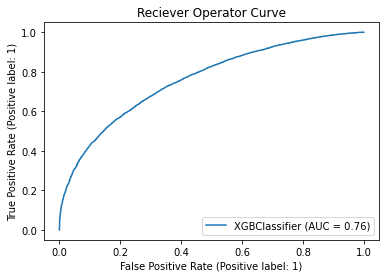

In [366]:
plot_roc_curve(xgb_model, X_test, y_test);
plt.title('Reciever Operator Curve')
plt.show()

The ROC curve measures plots the true positive rate (TPR) versus the false positive rate, as the threshold for predicting 1 changes.

- We measure the area under the curve. Whichs is 0.76
- If the TPR is always 1, the area under the curve is 1 (it cannot be larger). This is equivalent to perfect prediction.
- When the area under the curve is 0.50, this is equivalent to the baseline (chance) prediction (marked by the diagonal line).

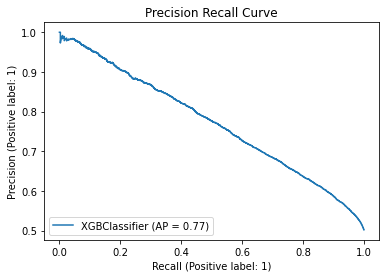

In [367]:
plot_precision_recall_curve(xgb_model, X_test, y_test);
plt.title('Precision Recall Curve')
plt.show()

---------

### XGBoost - RandomCV

- Min Child Weight - Minimum sum of instance weight (hessian) needed in a child. If the tree partition step results in a leaf node with the sum of instance weight less than min_child_weight, then the building process will give up further partitioning. The larger min_child_weight is, the more conservative the algorithm will be.
- Gamma - Minimum loss reduction required to make a further partition on a leaf node of the tree. The larger gamma is, the more conservative the algorithm will be.
- Subsample - ratio of the training instances. Setting it to 0.5 means that XGBoost would randomly sample half of the training data prior to growing trees. and this will prevent overfitting. Subsampling will occur once in every boosting iteration.
- colsample_bytree - is the subsample ratio of columns when constructing each tree.
- Maximum depth of a tree. Increasing this value will make the model more complex and more likely to overfit. 
- learning rate - Step size shrinkage used in update to prevents overfitting. After each boosting step, we can directly get the weights of new features, and eta shrinks the feature weights to make the boosting process more conservative.

In [34]:
# A parameter grid for XGBoost
# A parameter grid for XGBoost
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [5, 7, 9, 11],
        'n_estimators': [500, 600, 700],
        'learning_rate':[0.01, 0.05, 0.1]
        }

In [35]:
xgb = XGBClassifier( objective='binary:logistic', nthread=1)

In [36]:
folds = 5
param_comb = 15

random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=param_comb,
                                   n_jobs=5, cv=folds, verbose=3, random_state=1001 )

random_search.fit(X_train, y_train)


Fitting 5 folds for each of 15 candidates, totalling 75 fits


/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/xgbo

[11:24:17] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/5] END colsample_bytree=0.8, gamma=5, learning_rate=0.01, max_depth=7, min_child_weight=5, n_estimators=500, subsample=0.8;, score=0.695 total time=24.0min
[11:48:15] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/5] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=9, min_child_weight=5, n_estimators=700, subsample=0.8;, score=0.685 total time=29.5min
[12:17:47] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:39:37] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:24:17] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 5/5] END colsample_bytree=0.8, gamma=5, learning_rate=0.01, max_depth=7, min_child_weight=5, n_estimators=500, subsample=0.8;, score=0.693 total time=24.1min
[11:48:21] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/5] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=9, min_

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           enable_categorical=False, gamma=None,
                                           gpu_id=None, importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints...
                                           scale_pos_weight=None,
                                           subsample=None, tree_method=None,
                                      

------

In [37]:
random_search.best_score_

0.6993091537132987

In [38]:
random_search.best_params_

{'subsample': 0.6,
 'n_estimators': 600,
 'min_child_weight': 1,
 'max_depth': 9,
 'learning_rate': 0.05,
 'gamma': 5,
 'colsample_bytree': 0.6}

In [45]:
y_pred = random_search.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.69      0.73      0.71     11378
           1       0.71      0.67      0.69     11437

    accuracy                           0.70     22815
   macro avg       0.70      0.70      0.70     22815
weighted avg       0.70      0.70      0.70     22815



In [182]:
best_xgb = random_search.best_estimator_


In [183]:
print(roc_auc_score(y_test, y_pred))
print(f1_score(y_test, y_pred))


0.7016556711906952
0.6901760931883332


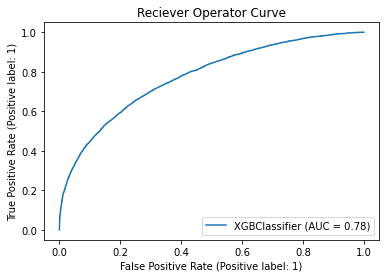

In [285]:
plot_roc_curve(best_xgb, X_test, y_test);
plt.title('Reciever Operator Curve')
plt.show()

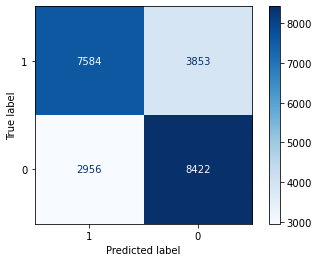

In [185]:
plot_confusion_matrix(best_xgb, X_test, y_test, cmap='Blues', labels=[1, 0], values_format='.0f')
plt.show()

#### Feature Importance

In [186]:
random_search.best_estimator_


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8,
              enable_categorical=False, gamma=1, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=9,
              min_child_weight=10, missing=nan, monotone_constraints='()',
              n_estimators=700, n_jobs=1, nthread=1, num_parallel_tree=1,
              predictor='auto', random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=0.6, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [187]:
feature_importance = best_xgb.feature_importances_


In [188]:
dict_features = {'feature_names': feature_names, 'feature_importance': feature_importance}


In [293]:
xgb_importance = pd.DataFrame(dict_features).sort_values('feature_importance', ascending=False).head(30)
xgb_importance

,feature_names,feature_importance
1154504,publication_datadriveninvestor,0.017780
1154508,publication_towardsdatascience,0.017499
1154507,publication_the-mission,0.013533
1154503,publication_better-marketing,0.011179
1154506,publication_swlh,0.005705
1154499,author_followers,0.005290
987508,write,0.005204
602011,operating cash,0.004003
144081,coffee,0.003777
533180,medium link,0.003512


In [ ]:
fig = px.bar(xgb_importance, y='feature_names',
             x='feature_importance', title='Feature Importance', width=700, height=800)

fig.show()

--------

In [177]:
random_search.best_score_

0.6987046632124353

In [178]:
random_search.best_params_

{'subsample': 0.6,
 'n_estimators': 700,
 'min_child_weight': 10,
 'max_depth': 9,
 'learning_rate': 0.01,
 'gamma': 1,
 'colsample_bytree': 0.8}

In [278]:
pd.DataFrame(random_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_subsample,param_n_estimators,param_min_child_weight,param_max_depth,param_learning_rate,param_gamma,param_colsample_bytree,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,1826.252826,109.464299,1.007501,0.039585,0.8,500,5,7,0.01,5,0.8,"{'subsample': 0.8, 'n_estimators': 500, 'min_c...",0.692573,0.695704,0.697863,0.695920,0.694193,0.695250,0.001776,8
1,2311.673093,89.209189,1.018806,0.051870,0.8,700,5,9,0.1,0.5,0.6,"{'subsample': 0.8, 'n_estimators': 700, 'min_c...",0.686528,0.692897,0.695920,0.701317,0.689983,0.693329,0.005063,11
2,931.296221,50.515378,0.653026,0.006932,1.0,500,5,5,0.1,0.5,0.6,"{'subsample': 1.0, 'n_estimators': 500, 'min_c...",0.692250,0.694085,0.696244,0.695272,0.691494,0.693869,0.001784,10
3,2418.292157,38.921632,1.133868,0.135598,0.8,700,10,7,0.01,1,0.8,"{'subsample': 0.8, 'n_estimators': 700, 'min_c...",0.693329,0.696136,0.699266,0.699374,0.694408,0.696503,0.002469,3
4,2825.178868,42.755260,1.089660,0.030729,0.8,700,10,11,0.1,2,0.6,"{'subsample': 0.8, 'n_estimators': 700, 'min_c...",0.687284,0.691278,0.698294,0.693653,0.689335,0.691969,0.003800,13
5,1723.683363,32.355586,0.834476,0.031648,0.6,500,5,9,0.1,1,0.6,"{'subsample': 0.6, 'n_estimators': 500, 'min_c...",0.686421,0.686097,0.689767,0.695704,0.692897,0.690177,0.003711,15
6,1196.130018,43.001445,0.709830,0.036638,0.6,600,1,5,0.1,1.5,0.6,"{'subsample': 0.6, 'n_estimators': 600, 'min_c...",0.688040,0.692034,0.692789,0.701533,0.685881,0.692055,0.005378,12
7,2198.058722,62.664898,1.018829,0.082259,0.6,600,1,9,0.05,5,0.6,"{'subsample': 0.6, 'n_estimators': 600, 'min_c...",0.695380,0.698402,0.703152,0.700237,0.690738,0.697582,0.004253,2
8,2044.381458,90.429278,0.727387,0.027831,1.0,700,1,5,0.1,5,1.0,"{'subsample': 1.0, 'n_estimators': 700, 'min_c...",0.689443,0.698294,0.699374,0.699698,0.692358,0.695833,0.004158,6
9,1288.987823,17.078619,0.760801,0.026692,0.6,500,10,7,0.1,1.5,0.6,"{'subsample': 0.6, 'n_estimators': 500, 'min_c...",0.686205,0.694085,0.694085,0.696136,0.683614,0.690825,0.004956,14


In [180]:
random_search.predict_proba(X_test)

array([[0.75263286, 0.24736716],
       [0.46653086, 0.53346914],
       [0.5058078 , 0.49419218],
       ...,
       [0.03010672, 0.9698933 ],
       [0.22396612, 0.7760339 ],
       [0.64041877, 0.3595812 ]], dtype=float32)

In [181]:
y_pred = random_search.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.69      0.74      0.71     11378
           1       0.72      0.66      0.69     11437

    accuracy                           0.70     22815
   macro avg       0.70      0.70      0.70     22815
weighted avg       0.70      0.70      0.70     22815



In [182]:
best_xgb = random_search.best_estimator_


In [183]:
print(roc_auc_score(y_test, y_pred))
print(f1_score(y_test, y_pred))


0.7016556711906952
0.6901760931883332


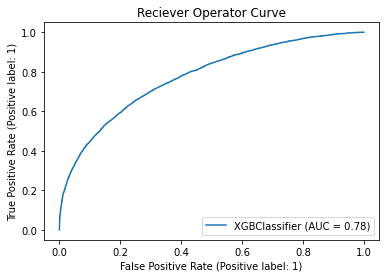

In [285]:
plot_roc_curve(best_xgb, X_test, y_test);
plt.title('Reciever Operator Curve')
plt.show()

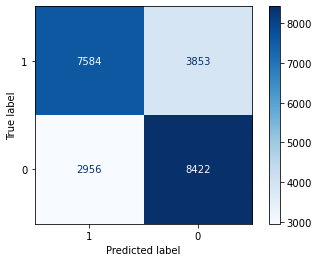

In [185]:
plot_confusion_matrix(best_xgb, X_test, y_test, cmap='Blues', labels=[1, 0], values_format='.0f')
plt.show()

#### Feature Importance

In [186]:
random_search.best_estimator_


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8,
              enable_categorical=False, gamma=1, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=9,
              min_child_weight=10, missing=nan, monotone_constraints='()',
              n_estimators=700, n_jobs=1, nthread=1, num_parallel_tree=1,
              predictor='auto', random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=0.6, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [187]:
feature_importance = best_xgb.feature_importances_


In [188]:
dict_features = {'feature_names': feature_names, 'feature_importance': feature_importance}


In [293]:
xgb_importance = pd.DataFrame(dict_features).sort_values('feature_importance', ascending=False).head(30)
xgb_importance

,feature_names,feature_importance
1154504,publication_datadriveninvestor,0.017780
1154508,publication_towardsdatascience,0.017499
1154507,publication_the-mission,0.013533
1154503,publication_better-marketing,0.011179
1154506,publication_swlh,0.005705
1154499,author_followers,0.005290
987508,write,0.005204
602011,operating cash,0.004003
144081,coffee,0.003777
533180,medium link,0.003512


In [303]:
fig = px.bar(xgb_importance, y='feature_names',
             x='feature_importance', title='Feature Importance', width=700, height=800)

fig.show()

----

### Gradient Boost - Basic

In [190]:
model = GradientBoostingClassifier(
    n_estimators=100,
    criterion='friedman_mse',
    loss='deviance',
    max_depth=3,
    learning_rate=1.0,
    random_state=1,
    verbose=2)

model.fit(X_train, y_train)
cv = cross_val_score(model, X_train, y_train, cv=5)

print('Training Score:', model.score(X_train, y_train))
print('Test Score:',model.score(X_test, y_test))
print('Cross Validation Score:', cv)
print('Mean cross Validation Score:',cv.mean())
print('Standard Deviation of Cross Validation Score:',cv.std())


      Iter       Train Loss   Remaining Time 
         1           1.2547            9.14m
         2           1.2193            8.20m
         3           1.1981            7.66m
         4           1.1907            7.25m
         5           1.1847            6.91m
         6           1.1768            6.93m
         7           1.1683            6.94m
         8           1.1646            6.67m
         9           1.1589            6.63m
        10           1.1552            6.46m
        11           1.1521            6.29m
        12           1.1496            6.12m
        13           1.1466            6.07m
        14           1.1430            6.05m
        15           1.1412            5.90m
        16           1.1391            5.78m
        17           1.1357            5.66m
        18           1.1332            5.55m
        19           1.1307            5.45m
        20           1.1289            5.34m
        21           1.1271            5.25m
        2

In [191]:
y_pred = model.predict(X_test)


In [192]:
print(roc_auc_score(y_test, y_pred))
print(f1_score(y_test, y_pred))


0.6785671850188548
0.6706479277984824


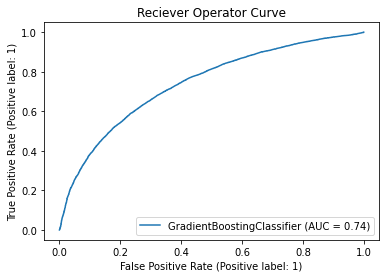

In [286]:
plot_roc_curve(model, X_test, y_test);
plt.title('Reciever Operator Curve')
plt.show()

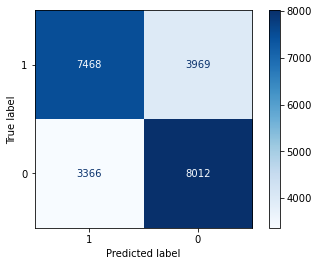

In [194]:
plot_confusion_matrix(model, X_test, y_test, cmap='Blues', labels=[1, 0], values_format='.0f')
plt.show()


In [195]:
gradient_boost_features = model.feature_importances_


In [196]:
dict_features = {'feature_names': feature_names, 'feature_importance': gradient_boost_features}
pd.DataFrame(dict_features).sort_values('feature_importance', ascending=False).head(30)


,feature_names,feature_importance
1154499,author_followers,0.237178
1154504,publication_datadriveninvestor,0.150518
1154508,publication_towardsdatascience,0.088500
1154500,number_of_words,0.026401
1154503,publication_better-marketing,0.019135
1154507,publication_the-mission,0.018392
1154517,subtitle_1,0.010742
989561,writing,0.010481
1154505,publication_startup-grind,0.007387
1154506,publication_swlh,0.006971


Generally, importance provides a score that indicates how useful or valuable each feature was in the construction of the boosted decision trees within the model. The more an attribute is used to make key decisions with decision trees, the higher its relative importance.

-----